# Wrangle and Analyze Data

## Table of Contents
- [Introduction](#intro)
- [Data Gathering](#gathering)
- [Data Assessing](#assessing)
- [Data Cleaning](#cleaning)
- [Storing and Acting on Wrangled Data](#acting)


<a id='intro'></a>
### Introduction
to get started, let's import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import requests
import os
import tweepy
from tweepy import OAuthHandler
import json
from pandas.io.json import json_normalize
from timeit import default_timer as timer
%matplotlib inline

<a id='gathering'></a>
### Data Gathering

Data always comes from different sources. In this project, Data is collected from 3 different sources. The twitter archive is a good source of data but it does not contain complete information such as tweets count , or retweets count. We'll use tweepy to to get data from Twitter API.

First load the archive data using panda's `read_csv` method. Our data contains alot of rows to visualy assess few (3) rows, take __transpose__ using `.head(3).T`

In [2]:
twitter_enhanced=pd.read_csv('twitter-archive-enhanced.csv') #read the csv file

In [3]:
twitter_enhanced.head(3).T #transpose of first 3 rows

0  \
tweet_id                                                   892420643555336193   
in_reply_to_status_id                                                     NaN   
in_reply_to_user_id                                                       NaN   
timestamp                                           2017-08-01 16:23:56 +0000   
source                      <a href="http://twitter.com/download/iphone" r...   
text                        This is Phineas. He's a mystical boy. Only eve...   
retweeted_status_id                                                       NaN   
retweeted_status_user_id                                                  NaN   
retweeted_status_timestamp                                                NaN   
expanded_urls               https://twitter.com/dog_rates/status/892420643...   
rating_numerator                                                           13   
rating_denominator                                                         10   
name                                                                  Phineas   
doggo                                                                    None   
floofer                                                                  None   
pupper                                                                   None   
puppo                                                                    None   

                                                                            1  \
tweet_id                                                   892177421306343426   
in_reply_to_status_id                                                     NaN   
in_reply_to_user_id                                                       NaN   
timestamp                                           2017-08-01 00:17:27 +0000   
source                      <a href="http://twitter.com/download/iphone" r...   
text                        This is Tilly. She's just checking pup on you....   
retweeted_status_id                                                       NaN   
retweeted_status_user_id                                                  NaN   
retweeted_status_timestamp                                                NaN   
expanded_urls               https://twitter.com/dog_rates/status/892177421...   
rating_numerator                                                           13   
rating_denominator                                                         10   
name                                                                    Tilly   
doggo                                                                    None   
floofer                                                                  None   
pupper                                                                   None   
puppo                                                                    None   

                                                                            2  
tweet_id                                                   891815181378084864  
in_reply_to_status_id                                                     NaN  
in_reply_to_user_id                                                       NaN  
timestamp                                           2017-07-31 00:18:03 +0000  
source                      <a href="http://twitter.com/download/iphone" r...  
text                        This is Archie. He is a rare Norwegian Pouncin...  
retweeted_status_id                                                       NaN  
retweeted_status_user_id                                                  NaN  
retweeted_status_timestamp                                                NaN  
expanded_urls               https://twitter.com/dog_rates/status/891815181...  
rating_numerator                                                           12  
rating_denominator                                                         10  
name                                                                   Archie  
doggo                                 

We have other data set in the form of tab seperated values of image prediction of each dogs for each `tweet_id`. We'll use request library to download the tab seprated values of image prediction. 

In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name=url.split('/')[-1] # create the name of file using url
if not os.path.isfile(file_name): # check if the file name exist or not, if not then it will execute the following code
    response =requests.get(url) # store the response of url
    with open(file_name, mode='wb') as file: #open the file in writting mode
        file.write(response.content) # write the content of the respone in file

As our downloaded or requested file is .tsv, We'll use same pandas `.read_csv` method but this time use sep='\t' in the arguments to tell the pandas that it is tab seprated file

In [5]:
image_pred=pd.read_csv('image-predictions.tsv',sep='\t')
image_pred.head(2).T

0  \
tweet_id                               666020888022790149   
jpg_url   https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
img_num                                                 1   
p1                                 Welsh_springer_spaniel   
p1_conf                                          0.465074   
p1_dog                                               True   
p2                                                 collie   
p2_conf                                          0.156665   
p2_dog                                               True   
p3                                      Shetland_sheepdog   
p3_conf                                         0.0614285   
p3_dog                                               True   

                                                        1  
tweet_id                               666029285002620928  
jpg_url   https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg  
img_num                                                 1  
p1                                                redbone  
p1_conf                                          0.506826  
p1_dog                                               True  
p2                                     miniature_pinscher  
p2_conf                                         0.0741917  
p2_dog                                               True  
p3                                    Rhodesian_ridgeback  
p3_conf                                           0.07201  
p3_dog                                               True

To gather data from Twitter API, first we have to configure and set the environment for requesting the data from Twitter API

In [6]:
#Setting up enviornment for tweepy
CONSUMER_KEY = "<consumer key>"
CONSUMER_SECRET = "<consumer secret>"
OAUTH_TOKEN = "<application key>"
OAUTH_TOKEN_SECRET = "<application secret>"

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True) # wait_on_rate_limit to limit the request rate to avoid spamming

In [7]:
tweet_ids = twitter_enhanced.tweet_id.values # Select the tweet_ids from twitter_enhanced dataset
len(tweet_ids) # gives the number of tweets

2356

In [8]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success
550: 805207613751304193
Success


Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807: 772102971039580160
Success
808

Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
1062: 741303864243200000
Success
10

Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
1311: 707038192327901184
Success
13

Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
1560: 688547210804498433
Success
15

Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
18

Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
2058: 671355857343524864
Success
2059: 671347597085433856
Success
20

Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
2308: 666826780179869698
Success
23

In [9]:
with open('tweet_json.txt', 'r') as json_file:
    print(json_file.readline()) # print first line to check the structure of json file

{"created_at": "Tue Aug 01 16:23:56 +0000 2017", "id": 892420643555336193, "id_str": "892420643555336193", "full_text": "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", "truncated": false, "display_text_range": [0, 85], "entities": {"hashtags": [], "symbols": [], "user_mentions": [], "urls": [], "media": [{"id": 892420639486877696, "id_str": "892420639486877696", "indices": [86, 109], "media_url": "http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg", "media_url_https": "https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg", "url": "https://t.co/MgUWQ76dJU", "display_url": "pic.twitter.com/MgUWQ76dJU", "expanded_url": "https://twitter.com/dog_rates/status/892420643555336193/photo/1", "type": "photo", "sizes": {"thumb": {"w": 150, "h": 150, "resize": "crop"}, "medium": {"w": 540, "h": 528, "resize": "fit"}, "small": {"w": 540, "h": 528, "resize": "fit"}, "large": {"w": 540, "h": 528, "resize": "fit"}}}]}, "extended_entities": {"media

We 'll use pandas `.read_json` method using `lines=True` to read each line as row

In [10]:
df_tweepy = pd.read_json('tweet_json.txt',lines=True)
df_tweepy = df_tweepy[['id','retweet_count','favorite_count']]
df_tweepy = df_tweepy.rename(columns={'id':'tweet_id'})
df_tweepy.head()

tweet_id  retweet_count  favorite_count
0  892420643555336193           7696           36129
1  892177421306343426           5692           31163
2  891815181378084864           3775           23479
3  891689557279858688           7860           39416
4  891327558926688256           8468           37642

<a id='assessing'></a>
### Data Assessing
#### Visual Assessment
To Assess our data visualy we'll set the pandas option for displaying every row and column as by defaut pandas truncate few column to fit the data in frame

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 10000

In [12]:
twitter_enhanced

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
5     891087950875897856                    NaN                  NaN   
6     890971913173991426                    NaN                  NaN   
7     890729181411237888                    NaN                  NaN   
8     890609185150312448                    NaN                  NaN   
9     890240255349198849                    NaN                  NaN   
10    890006608113172480                    NaN                  NaN   
11    889880896479866881                    NaN                  NaN   
12    889665388333682689                    NaN                  NaN   
13    889638837579907072                    NaN                  NaN   
14    889531135344209921                    NaN                  NaN   
15    889278841981685760                    NaN                  NaN   
16    888917238123831296                    NaN                  NaN   
17    888804989199671297                    NaN                  NaN   
18    888554962724278272                    NaN                  NaN   
19    888202515573088257                    NaN                  NaN   
20    888078434458587136                    NaN                  NaN   
21    887705289381826560                    NaN                  NaN   
22    887517139158093824                    NaN                  NaN   
23    887473957103951883                    NaN                  NaN   
24    887343217045368832                    NaN                  NaN   
25    887101392804085760                    NaN                  NaN   
26    886983233522544640                    NaN                  NaN   
27    886736880519319552                    NaN                  NaN   
28    886680336477933568                    NaN                  NaN   
29    886366144734445568                    NaN                  NaN   
30    886267009285017600           8.862664e+17         2.281182e+09   
31    886258384151887873                    NaN                  NaN   
32    886054160059072513                    NaN                  NaN   
33    885984800019947520                    NaN                  NaN   
34    885528943205470208                    NaN                  NaN   
35    885518971528720385                    NaN                  NaN   
36    885311592912609280                    NaN                  NaN   
37    885167619883638784                    NaN                  NaN   
38    884925521741709313                    NaN                  NaN   
39    884876753390489601                    NaN                  NaN   
40    884562892145688576                    NaN                  NaN   
41    884441805382717440                    NaN                  NaN   
42    884247878851493888                    NaN                  NaN   
43    884162670584377345                    NaN                  NaN   
44    883838122936631299                    NaN                  NaN   
45    883482846933004288                    NaN                  NaN   
46    883360690899218434                    NaN                  NaN   
47    883117836046086144                    NaN                  NaN   
48    882992080364220416                    NaN                  NaN   
49    882762694511734784                    NaN                  NaN   
50    882627270321602560                    NaN                  NaN   
51    882268110199369728                    NaN                  NaN   
52    882045870035918850                    NaN                  NaN   
53    881906580714921986                    NaN                  NaN   
54    881666595344535552                    NaN         

In [13]:
image_pred

tweet_id  \
0     666020888022790149   
1     666029285002620928   
2     666033412701032449   
3     666044226329800704   
4     666049248165822465   
5     666050758794694657   
6     666051853826850816   
7     666055525042405380   
8     666057090499244032   
9     666058600524156928   
10    666063827256086533   
11    666071193221509120   
12    666073100786774016   
13    666082916733198337   
14    666094000022159362   
15    666099513787052032   
16    666102155909144576   
17    666104133288665088   
18    666268910803644416   
19    666273097616637952   
20    666287406224695296   
21    666293911632134144   
22    666337882303524864   
23    666345417576210432   
24    666353288456101888   
25    666362758909284353   
26    666373753744588802   
27    666396247373291520   
28    666407126856765440   
29    666411507551481857   
30    666418789513326592   
31    666421158376562688   
32    666428276349472768   
33    666430724426358785   
34    666435652385423360   
35    666437273139982337   
36    666447344410484738   
37    666454714377183233   
38    666644823164719104   
39    666649482315059201   
40    666691418707132416   
41    666701168228331520   
42    666739327293083650   
43    666776908487630848   
44    666781792255496192   
45    666786068205871104   
46    666804364988780544   
47    666817836334096384   
48    666826780179869698   
49    666835007768551424   
50    666837028449972224   
51    666983947667116034   
52    666996132027977728   
53    667012601033924608   
54    667044094246576128   
55    667062181243039745   
56    667065535570550784   
57    667073648344346624   
58    667090893657276420   
59    667119796878725120   
60    667138269671505920   
61    667152164079423490   
62    667160273090932737   
63    667165590075940865   
64    667171260800061440   
65    667174963120574464   
66    667176164155375616   
67    667177989038297088   
68    667182792070062081   
69    667188689915760640   
70    667192066997374976   
71    667200525029539841   
72    667211855547486208   
73    667369227918143488   
74    667393430834667520   
75    667405339315146752   
76    667435689202614272   
77    667437278097252352   
78    667443425659232256   
79    667453023279554560   
80    667455448082227200   
81    667470559035432960   
82    667491009379606528   
83    667495797102141441   
84    667502640335572993   
85    667509364010450944   
86    667517642048163840   
87    667524857454854144   
88    667530908589760512   
89    667534815156183040   
90    667538891197542400   
91    667544320556335104   
92    667546741521195010   
93    667549055577362432   
94    667550882905632768   
95    667550904950915073   
96    667724302356258817   
97    667728196545200128   
98    667766675769573376   
99    667773195014021121   
100   667782464991965184   
101   667793409583771648   
102   667801013445750784   
103   667806454573760512   
104   667832474953625600   
105   667861340749471744   
106   667866724293877760   
107   667873844930215936   
108   667878741721415682   
109   667885044254572545   
110   667886921285246976   
111   667902449697558528   
112   667911425562669056   
113   667915453470232577   
114   667924896115245057   
115   667937095915278337   
116   668113020489474048   
117   668142349051129856   
118   668154635664932864   
119   668171859951755264   
120   668190681446379520   
121   668204964695683073   
122   668221241640230912   
123   668226093875376128   
124   668237644992782336   
125   668248472370458624   
126   668256321989451776   
127   668268907921326080   
128   668274247790391296   
129   668286279830867968   
130   668291999406125056   
131   668297328638447616   
132   668466899341221888   
133   668480044826800133   
134   668484198282485761   
135   668496999348633600   
136   668507509523615744   
137   668528771708952576   
138   668537837512433665   
139   668542336805281792   
140   668544745690562560   
141   668567822092664832   
142   668614

In [14]:
df_tweepy

tweet_id  retweet_count  favorite_count
0     892420643555336193           7696           36129
1     892177421306343426           5692           31163
2     891815181378084864           3775           23479
3     891689557279858688           7860           39416
4     891327558926688256           8468           37642
5     891087950875897856           2837           18966
6     890971913173991426           1846           11037
7     890729181411237888          17169           60856
8     890609185150312448           3907           26093
9     890240255349198849           6679           29843
10    890006608113172480           6665           28717
11    889880896479866881           4541           26127
12    889665388333682689           9104           44970
13    889638837579907072           4080           25321
14    889531135344209921           2054           14175
15    889278841981685760           4854           23598
16    888917238123831296           4097           27226
17    888804989199671297           3861           23953
18    888554962724278272           3170           18483
19    888078434458587136           3158           20398
20    887705289381826560           4905           28307
21    887517139158093824          10723           43415
22    887473957103951883          16371           64329
23    887343217045368832           9536           31500
24    887101392804085760           5431           28655
25    886983233522544640           6986           32675
26    886736880519319552           2930           11224
27    886680336477933568           4076           21038
28    886366144734445568           2885           19780
29    886267009285017600              4             110
30    886258384151887873           5754           26197
31    886054160059072513            100               0
32    885984800019947520           6117           30483
33    885528943205470208           5822           33640
34    885518971528720385           3401           19168
35    885311592912609280          16869               0
36    885167619883638784           3982           20491
37    884925521741709313          16473           72162
38    884876753390489601           5081           26051
39    884562892145688576           4281           22736
40    884441805382717440           5193           25363
41    884247878851493888          18504           67927
42    884162670584377345           2731           19106
43    883838122936631299           3131           20469
44    883482846933004288           9003           42892
45    883360690899218434           3369           21221
46    883117836046086144           6051           34731
47    882992080364220416           3548           22348
48    882762694511734784           4453           26461
49    882627270321602560           5537           26213
50    882268110199369728          10553           41957
51    882045870035918850           4457           27447
52    881906580714921986           3099           22783
53    881666595344535552           9728           47400
54    881633300179243008              7             117
55    881536004380872706          14550           46300
56    881268444196462592           4807           21752
57    880935762899988482           2544           16002
58    880872448815771648           3490           19927
59    880465832366813184           5671           26669
60    880221127280381952           3801           25243
61    880095782870896641           3957           25850
62    879862464715927552           3191           20965
63    879674319642796034             10             296
64    879492040517615616           2907           21995
65    879415818425184262          40542           99039
66    879376492567855104           2855           15738
67    879130579576475649           6204               0
68    879050749262655488           4283           21105
69    879008229531029506           2445           17808
70    878776093423087618           3731 

#### Programmatic Assessment

In [15]:
twitter_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
df_tweepy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [18]:
all_columns = pd.Series(list(twitter_enhanced) + list(image_pred) + list(df_tweepy))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

In [19]:
list(twitter_enhanced)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [20]:
twitter_enhanced.sample(5)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1107  734776360183431168                    NaN                  NaN   
30    886267009285017600           8.862664e+17         2.281182e+09   
311   835297930240217089                    NaN                  NaN   
1157  724405726123311104                    NaN                  NaN   
1155  724983749226668032                    NaN                  NaN   

                      timestamp  \
1107  2016-05-23 16:01:50 +0000   
30    2017-07-15 16:51:35 +0000   
311   2017-02-25 01:18:40 +0000   
1157  2016-04-25 01:12:38 +0000   
1155  2016-04-26 15:29:30 +0000   

                                                                                  source  \
1107  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
30    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
311   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1157  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1155  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                    text  \
1107                         This is Livvie. Someone should tell her it's been 47 years since Woodstock. Magical eyes tho 11/10 would stare into https://t.co/qw07vhVHuO   
30                                                             @NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution   
311   Meet Ash. He's a Benebop Cumberplop. Quite rare. Fairly portable. Lil sandy tho. Clearly knows something you don't. 12/10 would hug softly https://t.co/1U0z6r5LSO   
1157                                          This is Ashleigh. She's having Coachella withdrawals. Didn't even go tho. 10/10 stay strong pupper https://t.co/nRUaKWnJfH   
1155                        This is Fred-Rick. He dabbles in parkour. The elevation gives him power. 12/10 hopefully visiting a mailbox near you https://t.co/qFqLtudIiD   

      retweeted_status_id  retweeted_status_user_id  \
1107                  NaN                       NaN   
30                    NaN                       NaN   
311                   NaN                       NaN   
1157                  NaN                       NaN   
1155                  NaN                       NaN   

     retweeted_status_timestamp  \
1107                        NaN   
30                          NaN   
311                         NaN   
1157                        NaN   
1155                        NaN   

                                                        expanded_urls  \
1107  https://twitter.com/dog_rates/status/734776360183431168/photo/1   
30                                                                NaN   
311   https://twitter.com/dog_rates/status/835297930240217089/photo/1   
1157  https://twitter.com/dog_rates/status/724405726123311104/photo/1   
1155  https://twitter.com/dog_rates/status/724983749226668032/photo/1   

      rating_numerator  rating_denominator      name doggo floofer  pupper  \
1107                11                  10    Livvie  None    None    None   
30                  12                  10      None  None    None    None   
311                 12                  10       Ash  None    None    None   
1157                10                  10  Ashleigh  None    None  pupper   
1155                12                  10      Fred  None    None    None   

     puppo  
1107  None  
30    None  
311   None  
1157  None  
1155  None

In [21]:
twitter_enhanced.name.value_counts()

None              745
a                  55
Charlie            12
Oliver             11
Lucy               11
Cooper             11
Lola               10
Tucker             10
Penny              10
Winston             9
Bo                  9
the                 8
Sadie               8
Bailey              7
an                  7
Toby                7
Daisy               7
Buddy               7
Dave                6
Leo                 6
Jack                6
Bella               6
Jax                 6
Stanley             6
Scout               6
Koda                6
Rusty               6
Oscar               6
Milo                6
very                5
Sammy               5
Finn                5
Chester             5
Sunny               5
Gus                 5
Bentley             5
Alfie               5
Phil                5
Louis               5
George              5
Oakley              5
Larry               5
Scooter             4
Gary                4
Loki                4
one       

In [22]:
#The name with lower case are not actual name
dognames = list(twitter_enhanced.name)
empty = []
for element in dognames:
    n = re.match('([a-z]+)', element)
    if n:
        empty.append(n.groups())
empty

[('such',),
 ('a',),
 ('quite',),
 ('quite',),
 ('quite',),
 ('not',),
 ('one',),
 ('incredibly',),
 ('a',),
 ('mad',),
 ('an',),
 ('very',),
 ('a',),
 ('very',),
 ('just',),
 ('my',),
 ('one',),
 ('not',),
 ('his',),
 ('one',),
 ('a',),
 ('a',),
 ('a',),
 ('an',),
 ('very',),
 ('actually',),
 ('a',),
 ('just',),
 ('getting',),
 ('mad',),
 ('very',),
 ('this',),
 ('unacceptable',),
 ('all',),
 ('a',),
 ('old',),
 ('a',),
 ('infuriating',),
 ('a',),
 ('a',),
 ('a',),
 ('an',),
 ('a',),
 ('a',),
 ('very',),
 ('getting',),
 ('just',),
 ('a',),
 ('the',),
 ('the',),
 ('actually',),
 ('by',),
 ('a',),
 ('officially',),
 ('a',),
 ('the',),
 ('the',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('life',),
 ('a',),
 ('one',),
 ('a',),
 ('a',),
 ('a',),
 ('light',),
 ('just',),
 ('space',),
 ('a',),
 ('the',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('an',),
 ('a',),
 ('the',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 ('a',),
 (

In [23]:
wrong_name = [item for t in set(empty) for item in t]
wrong_name

['just',
 'the',
 'quite',
 'getting',
 'a',
 'infuriating',
 'space',
 'this',
 'officially',
 'mad',
 'life',
 'by',
 'light',
 'all',
 'an',
 'my',
 'old',
 'his',
 'very',
 'one',
 'such',
 'not',
 'unacceptable',
 'incredibly',
 'actually']

In [24]:
twitter_enhanced.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [25]:
twitter_enhanced.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [26]:
twitter_enhanced.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [27]:
twitter_enhanced.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [28]:
sum(twitter_enhanced.duplicated())

0

In [29]:
twitter_enhanced.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [30]:
twitter_enhanced.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [31]:
image_pred.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [32]:
# What is a range of p1_conf values? They should be between 0 and 1.
image_pred.describe()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

#### Quality Issue
1. Some tweets do not contain an image
2. Timestamp is string and should be datetime
3. Tweet id should be string not integer
4. Dog stage and img_num are string they must be categorical
5. p1, p2, and p3 are inconsistent
6. Name column contains articles instead of names
7. Remove retweets
8. Some columns are extraneous and must be deleted


#### Tidiness Issue
1. Dog breed could be in one column instead of 4
2. All the dataframes could be fit into 1 master data

<a id='cleaning'></a>
### Data Cleaning
Before starting the cleaning proccess create the copies of each dataframes

In [33]:
clean_twitter_enhanced = twitter_enhanced.copy()
clean_image_pred = image_pred.copy()
clean_df_tweepy = df_tweepy.copy()

##### Tidiness Issue 1
##### Define
In twitter_enhanced dog stage are in 4 different columns the must be in one column
##### Code

In [34]:
clean_twitter_enhanced['stage']= ['doggo' if 'doggo' in i
                                 else 'pupper' if 'pupper' in i
                                 else 'floofer' if 'floofer' in i
                                 else 'floof' if 'floof' in i
                                 else 'puppo' if 'puppo' in i
                                 else np.nan for i in clean_twitter_enhanced['text'].str.lower()]
clean_twitter_enhanced['stage'] = clean_twitter_enhanced['stage'].astype('category')
clean_twitter_enhanced.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

###### Test

In [35]:
clean_twitter_enhanced.sample(5).T

1930  \
tweet_id                                                                                                      674038233588723717   
in_reply_to_status_id                                                                                                        NaN   
in_reply_to_user_id                                                                                                          NaN   
timestamp                                                                                              2015-12-08 01:30:12 +0000   
source                                        <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
text                        This is Kaiya. She's an aspiring shoe model. 12/10 follow your dreams pupper https://t.co/nX8FiGRHvk   
retweeted_status_id                                                                                                          NaN   
retweeted_status_user_id                                                                                                     NaN   
retweeted_status_timestamp                                                                                                   NaN   
expanded_urls                                                    https://twitter.com/dog_rates/status/674038233588723717/photo/1   
rating_numerator                                                                                                              12   
rating_denominator                                                                                                            10   
name                                                                                                                       Kaiya   
stage                                                                                                                     pupper   

                                                                                                                                                                                                                       679   \
tweet_id                                                                                                                                                                                                 789137962068021249   
in_reply_to_status_id                                                                                                                                                                                                   NaN   
in_reply_to_user_id                                                                                                                                                                                                     NaN   
timestamp                                                                                                                                                                                         2016-10-20 16:15:26 +0000   
source                                                                                                                                   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
text                                                                             This is Bo. He's a West Congolese Bugaboop Snuggle. Rather exotic. Master of the head tilt. 12/10 would pay to pet https://t.co/2jwxxtNzoN   
retweeted_status_id                                                                                                                                                                                                     NaN   
retweeted_status_user_id                                                                                                                                                                                                NaN   
retweeted_status_timestamp                                                                                                              

##### Tidiness Issue 2
also deals __Quality issue 1__
##### Define
In order to satisfy the project motivation which was prediction of dog breed from image. Inner Merge the dataset on tweet_id.
##### Code

In [36]:
clean_twitter_enhanced = pd.merge(left=clean_twitter_enhanced, right=clean_image_pred, how='inner', on='tweet_id')
clean_master_df = pd.merge(left=clean_twitter_enhanced, right=clean_df_tweepy, how='inner', on='tweet_id')

##### Test

In [37]:
clean_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 27 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null object
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
stage                         381 non-null category
jpg_url                       2059 non-null object
img_num                       2059 non-null int64
p1                            2059 non-null object
p1_conf                       2059 

##### Quality Issue 2,3,4
##### Define
Change the data types of column, timestamp should be in  DateTime and tweet id should in string object not integer and img_num should be categorical
##### Code

In [38]:
clean_master_df['tweet_id']= clean_master_df['tweet_id'].astype('str')
clean_master_df['timestamp']= pd.to_datetime(clean_master_df['timestamp'])
clean_master_df['img_num']= clean_master_df['tweet_id'].astype('category')

#### Test

In [39]:
clean_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 27 columns):
tweet_id                      2059 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null datetime64[ns]
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
stage                         381 non-null category
jpg_url                       2059 non-null object
img_num                       2059 non-null category
p1                            2059 non-null object
p1_conf                

##### Quality Issue 5
##### Definition
replace all '_' and '-' with spaces, and everything in lower cases in p1, p2 and p3
##### Code

In [40]:
clean_master_df['p1'] = clean_master_df['p1'].str.lower().str.replace('_', ' ').str.replace('-', ' ')
clean_master_df['p2'] = clean_master_df['p2'].str.lower().str.replace('_', ' ').str.replace('-', ' ')
clean_master_df['p3'] = clean_master_df['p3'].str.lower().str.replace('_', ' ').str.replace('-', ' ')

#### Test

In [41]:
clean_master_df[['p1','p2','p3']].sample(8)

p1                        p2                  p3
944   golden retriever            great pyrenees      cocker spaniel
273             kuvasz          golden retriever      english setter
1991            vizsla  chesapeake bay retriever          weimaraner
1251        toy poodle                     teddy    miniature poodle
2025             llama             irish terrier               dingo
1207        pomeranian                      chow          sunglasses
170         car mirror                 seat belt     standard poodle
94    golden retriever            great pyrenees  labrador retriever

##### Quality Issue 6
##### Define
Remove the wrong names from the name column
##### Code

In [42]:
for i in wrong_name:
    clean_master_df.loc[clean_master_df.name == i, 'name'] = None

##### Test

In [43]:
clean_master_df.name.value_counts()

None              573
Charlie            10
Oliver             10
Cooper             10
Penny              10
Tucker             10
Lucy                9
Sadie               8
Lola                8
Winston             8
Bo                  8
Daisy               7
Toby                7
Scout               6
Rusty               6
Dave                6
Milo                6
Koda                6
Bella               6
Stanley             6
Jax                 6
Bailey              6
Louis               5
Buddy               5
Alfie               5
Larry               5
Leo                 5
Chester             5
Oscar               5
Loki                4
Winnie              4
Sophie              4
Archie              4
Gary                4
Bruce               4
Duke                4
Phil                4
Ruby                4
Bentley             4
Oakley              4
Chip                4
Brody               4
Bear                4
Dexter              4
Clark               4
Jerry     

##### Quality Issue 7
##### Define
Remove reweets from the data set using `isnull` method of pandas
##### Code

In [44]:
clean_master_df = clean_master_df[pd.isnull(clean_master_df['retweeted_status_id'])]
clean_master_df = clean_master_df[pd.isnull(clean_master_df['in_reply_to_status_id'])]

##### Test

In [45]:
clean_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2058
Data columns (total 27 columns):
tweet_id                      1964 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1964 non-null datetime64[ns]
source                        1964 non-null object
text                          1964 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1964 non-null object
rating_numerator              1964 non-null int64
rating_denominator            1964 non-null int64
name                          1866 non-null object
stage                         363 non-null category
jpg_url                       1964 non-null object
img_num                       1964 non-null category
p1                            1964 non-null object
p1_conf                     

##### Quality Issue 8
##### Define
remove extra columns from the master dataframe using panda's `.drop` method

In [46]:
clean_master_df.drop(['in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id',
         'retweeted_status_timestamp','in_reply_to_status_id'], axis=1, inplace =True )

##### Test

In [47]:
clean_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2058
Data columns (total 22 columns):
tweet_id              1964 non-null object
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1866 non-null object
stage                 363 non-null category
jpg_url               1964 non-null object
img_num               1964 non-null category
p1                    1964 non-null object
p1_conf               1964 non-null float64
p1_dog                1964 non-null bool
p2                    1964 non-null object
p2_conf               1964 non-null float64
p2_dog                1964 non-null bool
p3                    1964 non-null object
p3_conf               1964 non-null float64
p3_dog                1964 non-null bool
retweet_count         1964 

<a id='acting'></a>
### Storing and Acting on Wrangled Data

In [48]:
clean_master_df.reset_index(inplace=True)
clean_master_df.to_csv('twitter_master.csv', encoding = 'utf-8') #saved

#### Top 10 most common names

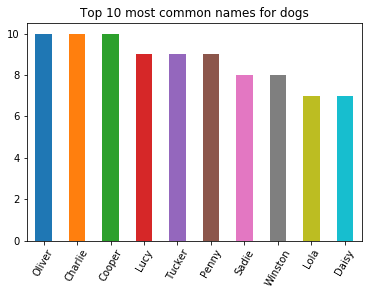

In [49]:
top_names = clean_master_df.name.value_counts().nlargest(11)[1:] #the first was none thats why used [1:]
top_names.plot(kind='bar')
plt.xticks(rotation=60)
plt.title('Top 10 most common names for dogs')
plt.show()

The most common name used are Charlie with more than 10 occurence followed by Lucy, Cooper, Oliver having 10 occurences

In [50]:
clean_master_df.stage.value_counts()

pupper     225
doggo       78
floof       27
puppo       26
floofer      7
Name: stage, dtype: int64

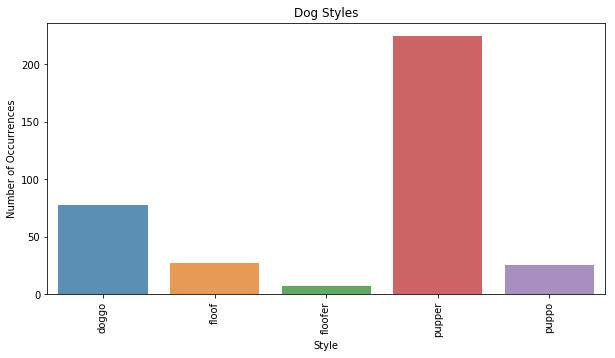

In [51]:
stage_count  = clean_master_df.stage.value_counts()
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(stage_count.index, stage_count.values, alpha=0.8).set(xlabel='Style', ylabel='Number of Occurrences',title='Dog Styles')
plt.xticks(rotation=90)
plt.show()

The most common style is pupper

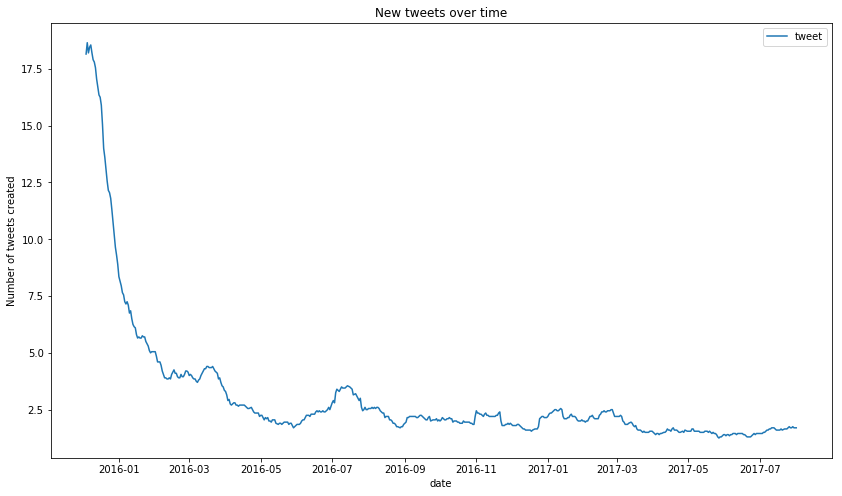

In [52]:
clean_master_df['date'] = clean_master_df['timestamp'].dt.date
clean_master_df['tweet'] = 1

df1 = clean_master_df[['date', 'tweet']].groupby(['date']).sum() # alternatively .count() could be used

# Use moving averages to smooth the line
df1['tweet'] = df1['tweet'].rolling(window=20).mean()

# Plot
df1.plot(figsize=(14, 8), title='New tweets over time')
plt.ylabel('Number of tweets created')
plt.show()

The tweets daily frequency was initialy at peek and drastically settle to average 2.5 tweets per day

In [53]:
# Add rewteets and favorites to the picture
df = clean_master_df[['date', 'retweet_count', 'favorite_count']]

# Retweets
df2 = df[['date', 'retweet_count']].groupby(['date']).sum()
df2['retweet_count'] = df2['retweet_count'].rolling(window=20).mean()
# Favorites
df3 = df[['date', 'favorite_count']].groupby(['date']).sum()
df3['favorite_count'] = df3['favorite_count'].rolling(window=20).mean()


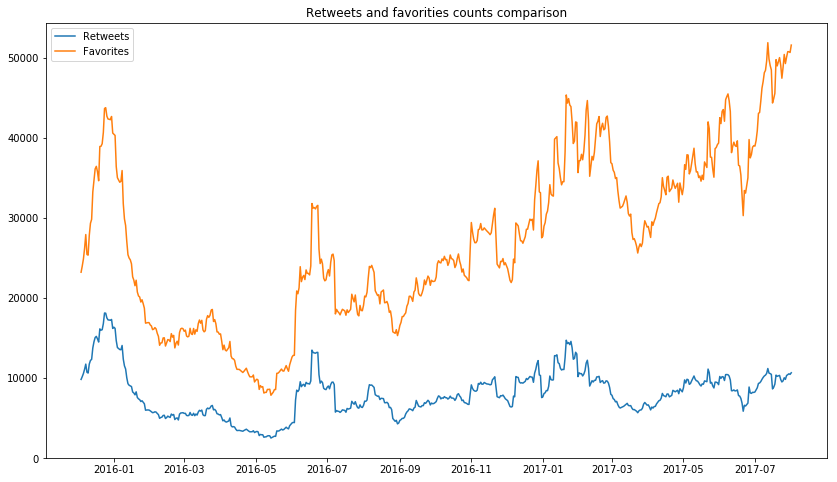

In [54]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(14,8))

axs.set_title('Retweets and favorities counts comparison')

axs.plot(df2, label='Retweets')
axs.plot(df3, label='Favorites')
axs.legend()

plt.show()

There is some relationship between retweets and favorite the more the favorite the more the retweets are